<font color='#315aa0'>**Velarion - Data Modeling**</font>
---

## <font color='#b0aeae'>**Índice**</font>

1. Descripción del Notebook
2. Configuraciones
   * Importación de librerías
   * Paths
   * Paleta de Colores del Proyecto
   * Funciones
3. Extracción de datos
4. Preparación de datos
   * Feature Encoding
   * Train Test Split
   * Escalado Variables Numéricas
   * Balance del Dataset
5. Modelado
   * Baseline Model - Decision Tree Classifier

# <font color='#315aa0'>**Descripción del Notebook**</font>

# <font color='#315aa0'>**Cofiguraciones**</font>

## <font color='#c37171'>**Importación de librerías**</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List
import os

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC, SMOTE

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## <font color='#c37171'>**Paths**</font>

In [3]:
# Obtiene el path actual
PROJECT_PATH = os.getcwd()

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
GENERAL_IMG_PATH = PROJECT_PATH / img

models_img = Path('models_img')
IMG_PATH = GENERAL_IMG_PATH/ models_img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports

dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directorio creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\src

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\img\models_img

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\models

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\Fintech_NC\reports



## <font color='#c37171'>**Paleta de Colores del Proyecto**</font>

**Bordós / Rojos**

<span style="display:inline-block; width:20px; height:20px; background:#620c0c; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#8b1f1f; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#a14b4b; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#c37171; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#e29c9c; margin-right:5px;"></span>

**Grises / Neutros**

<span style="display:inline-block; width:20px; height:20px; background:#5a5858; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#8c8a8a; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#b0aeae; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#d3d1d1; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#eae7e6; margin-right:5px;"></span>

**Azules**

<span style="display:inline-block; width:20px; height:20px; background:#0d1b3d; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#152a55; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#1e3a6c; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#274a84; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#315aa0; margin-right:5px;"></span>

**Cremas / Mostazas**

<span style="display:inline-block; width:20px; height:20px; background:#FCB53B; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDB860; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDC584; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDD2A9; margin-right:5px;"></span> 
<span style="display:inline-block; width:20px; height:20px; background:#FDE0CE; margin-right:5px;"></span>

In [4]:
BORDO_1, BORDO_2, BORDO_3, BORDO_4, BORDO_5 = '#620c0c', '#8b1f1f', '#a14b4b', '#c37171', '#e29c9c' 
GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = '#5a5858', '#8c8a8a', '#b0aeae', '#d3d1d1', '#eae7e6' 
AZUL_1, AZUL_2, AZUL_3, AZUL_4, AZUL_5 = '#0d1b3d', '#152a55', '#1e3a6c', '#274a84', '#315aa0' 
CREMA_1, CREMA_2, CREMA_3, CREMA_4, CREMA_5 = '#FCB53B', '#FDB860', '#FDC584', '#FDD2A9', '#FDE0CE'

In [5]:
# Definir los colores personalizados
custom_colors = [

    '#620c0c', '#8b1f1f', '#a14b4b', '#c37171', '#e29c9c',
    '#FCB53B', '#FDB860', '#FDC584', '#FDD2A9', '#FDE0CE',
    '#315aa0', '#274a84', '#1e3a6c', '#152a55', '#0d1b3d'  
    
]

# Crear el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
reverse_custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors[::-1])

## <font color='#c37171'>**Funciones**</font>

In [6]:
def metricas_evaluacion(modelo, 
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       umbral: float=None):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
    
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
            
        x_test: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para evaluar el modelo
            
        y_test:
            Pandas Series con las etiquetas reales de los datos utilizados para evaluar el modelo
            
        nombre: str
            Nombre que identificará el modelo para comparaciones
            
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo, umbral utilizado y metricas: Accuracy, Precision, Recall, F1-score, AUC
    """
    
    if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50
    else:
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueEror('El modelo no cuenta con el método "predict_proba"')
    
    return metricas

In [7]:
def cv_score_interval(results, 
                      nombre: str, 
                      score:str='Recall'):
    """
    Calcula e imprime el intervalo de confianza del 95% para una métrica de evaluación,
    a partir de los resultados de validación cruzada.

    Este análisis ayuda a entender la variabilidad del desempeño del modelo y 
    en qué rango se espera que se encuentre la métrica seleccionada (ej. recall, precisión, F1).
    ------------------------------------------------------------------------------------------
    Parámetros:
    
        results : dict o DataFrame-like
            Resultados obtenidos mediante cross_validate(), conteniendo la clave 'test_score'
            con los valores de la métrica evaluada en cada pliegue.
    
        nombre : str
            Nombre del modelo evaluado, utilizado para mostrarlo en los mensajes impresos.
    
        score : str - Default: Recall
            Nombre de la métrica evaluada (ej. 'Recall', 'F1-score'), utilizado con fines descriptivos.
    ------------------------------------------------------------------------------------------
    Returns:
    
        Imprime en pantalla el promedio, la desviación estándar y el intervalo
        de confianza del 95% para la métrica especificada.

    """
    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)
    
    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

In [8]:
def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame, 
                  y: pd.core.series.Series, 
                  name: str,
                  save: str,
                  save_path: Path=IMG_PATH,
                  umbral: float=None):

    """
    Función que grafíca la matriz de confusión de un modelo y guarda la figura en el Path indicado
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        model: Modelo sklearn
            Modelo de clasificación binaria que cuente con el método .predict()
            
        x: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas
            
        y: pandas.core.series.Series
            Serie con el vector de etiquetas verdaderas (variable respuesta)
            
        name: str
            Nombre del modelo para el título de la figura
            
        save: str
            Nombre para guardar la figura como confmat_{nombre}.png
            
        save_path: Path
            Ruta donde debe guardarse la figura
    ---------------------------------------------------------------------------------------------
    Returns:
        Figura con matriz de confusion obtenida por el modelo seleccionado
    """
    
    if umbral == None:
        y_pred = model.predict(x)
    else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int) 
        
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    
    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)
    
    fig.savefig(save_path / f'confmat_{save}.png',
                transparent=True,
                dpi=300,
                bbox_inches=None)

In [9]:
def plot_umbrales(modelo,
                  score: str,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  caja_x: float,
                  caja_y: float,
                  nombre: str):
    """
    Función que genera gráfico para determinar el mejor umbral de decisión según F1-score
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        modelo: Scikit-learn model
            Para que la función trabaje correctamente debe contar con el método predict_proba
            
        score: str
            Toma solo valores: 'F1-score', 'Recall' y 'Precision'. Determina la métrica sobre la cual se quieren evaluar
            los umbrales de decisión.
            
        x: pandas.core.frames.DataFrame
            DataFrame con el conjunto de variables explicativas para realizar predicciones
            
        y: pandas.core.series.Series
            Serie con las etiquetas correspondientes a cada observación.
            
        caja_x:
            Valor para desplazar hacia la derecha la caja de texto con el valor del mejor umbral (usar valor negativo para 
            desplazar a la izquierda)
            
        caja_y:
            Valor para desplazar hacia abajo la caja de texto con el valor del mejor umbral (usar valor negativo para
            desplazar hacia arriba)
            
        nombre:
            Nombre del modelo sobre el cual se está calculando el umbral (SuperTitle)
    ----------------------------------------------------------------------------------------------
    Returns:
        Gráfico matpltolib con curva de umbrales de decisión y punto óptimo según F1-Score.
    """
    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []
    if hasattr(modelo, 'predict_proba'):    
        modelo_pred_proba = modelo.predict_proba(x)[:, 1]
    else:
        raise ValueError('El modelo no cuenta con el método predict_proba')
    for t in umbrales:        
        y_pred = (modelo_pred_proba >= t).astype(int)
        scores.append(f1_score(y, y_pred))
    
    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')
    
    plt.plot(umbrales, scores, label='F1-Score', color=AZUL_1)
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)
    
    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color=CREMA_1, zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return mejor_umbral, fig

In [10]:
def plot_precision_recall_curve(modelo,
                                x: pd.core.frame.DataFrame,
                                y: pd.core.series.Series,
                                nombre:str):
    """
    Grafica la curva Precision vs Recall para un modelo binario.

    Esta visualización permite analizar el trade-off entre la Precisión y el Recall 
    a medida que varía el umbral de decisión. Es especialmente útil en contextos de 
    clases desbalanceadas.
    --------------------------------------------------------------------------------
    Parámetros:     
        modelo: estimador de sklearn
            Modelo entrenado con un método predict_proba implementado.
            
        x: pandas.core.frame.DataFrame
            Conjunto de variables independientes para la predicción.
            
        y: pandas.core.series.Series
            Valores reales (observados) de la variable objetivo.
            
        nombre: str
            Nombre que se le dará a la curva en la leyenda del gráfico.
    --------------------------------------------------------------------------------
    Returns:
        Muestra un gráfico matplotlib con la curva Precision vs Recall.
    """
    y_pred = modelo.predict_proba(x)[:, 1]
    
    # Calcular precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    
    # Graficar la curva
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color=AZUL_1, label='Baseline Model')
    plt.title(f'{nombre}: Curva Precision-Recall', fontsize=18, fontweight='bold')
    plt.xlabel('Recall', fontsize=13)
    plt.ylabel('Precision', fontsize=13)

    plt.grid(True, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

In [11]:
def plot_analisis_variables(df: pd.core.frame.DataFrame, 
                            analisis: str,
                            nombre_modelo: str, 
                            save: str,
                            n_vars: int= None,
                            save_path: Path=IMG_PATH,
                            space: float=0.5,
                            cmap=custom_cmap):
    """
    Funcion que permite visualizar Importancias o Coeficientes de modelos, guardando la figura en la ruta correspondiente.
    -----------------------------------------------------------------------------------
    Parámetros:
        df: pandas.core.frame.DataFrame
            DataFrame con las variables del modelo y sus importancias o coeficientes.
            
        analisis: str
            Acepta solo 'Importancia' o 'Coeficiente' para determinar qué analizar.
            
        nombre_modelo: str
            Nombre que aparecerá en el título del gráfico.
            
        save: str
            Nombre que se utilizará para guardar el gráfico con: "{analisis}_variables_{save}.png"
            
        n_vars: int
            Cantidad de variables que se desean analizar. Para análisis de coeficientes toma (n_vars / 2) para head y tail.
            
        save_path: Path
            Ruta para guardar el gráfico. Default IMG_PATH
    -----------------------------------------------------------------------------------
    Returns:
        Gráfico de barras horizontales con Importancia o Coeficientes de variables determinadas por modelo.
    """
    
    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Esta función acepta solo los valores "Importancia" o "Coeficiente" para el parámetro <analisis>') 
        
    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df2 = df.tail(n_vars)
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left', fontweight='bold')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)

    
    x_max = df[analisis].max()
    x_min = df[analisis].min()
    
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':                
                if width > 0:
                    ax.text(
                        (width + (x_max * space)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * space)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * space)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )
        
    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1) 
    plt.tight_layout()

    fig.savefig(IMG_PATH / f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()

In [12]:
def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6),
                 path: Path=IMG_PATH):
    """
    Función que genera una tabla visual en formato imagen a partir de un DataFrame dado.
    ---------------------------------------------------------------------------------------------------------
    Parámetros:
    
        df: pandas.core.frame.DataFrame
            DataFrame con los datos que se desean visualizar en formato tabular.
            
        title: str
            Título que se mostrará en la parte superior de la tabla.
            
        save: str
            Nombre con el que se guardará la imagen de la tabla como archivo .png.
            
        figsize: Tuple
            Tamaño de la figura (ancho, alto). Default: (8, 6).
            
        path: Path
            Ruta donde se guardará la imagen. Default: IMG_PATH.
    ---------------------------------------------------------------------------------------------------------
    Returns:
        Imagen .png con la tabla renderizada y coloreada, útil para presentaciones ejecutivas o informes.
    """
    
    # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')
    
    colors = [GRIS_3, GRIS_4]
    
    
    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]
    
    cols_names = df.columns        
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()
    
    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=[CREMA_1 for i in range(df.shape[0])],
                     cellColours=cell_colors)
    
    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)
        
    plt.title(f'{title}', fontsize=18, fontweight='bold')
    
    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)
    
    plt.tight_layout()
    
    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')
    
    
    plt.show()

# <font color='#315aa0'>**Extracción de Datos**</font>

In [13]:
df = pd.read_csv(DATA_PATH / 'ml_dataset.csv')

In [14]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,10063.934194,12958.129022,9,1.000000,-0.285714,13.127358,16.287033,38,3.000000,-0.666667,0.000000,0.000000,0.000000,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,9382.067586,9406.428411,1,0.125000,0.333333,18.790853,14.050155,4,0.000000,-0.250000,0.083333,0.027778,0.057824,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,18039.062607,22345.149231,1,-0.237736,-0.178218,30.495574,28.613008,7,-0.256410,-0.275862,0.000000,0.000000,0.000000,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,6639.424146,9454.027637,7,-0.050000,-0.894737,9.475486,7.698650,18,7.000000,-0.625000,0.000000,0.000000,0.000000,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,10679.853051,20107.223489,2,-0.384615,0.062500,21.316275,12.690932,11,-0.083333,-0.090909,0.000000,0.100000,0.057735,0


In [15]:
ids = df['CustomerId']

In [16]:
df.drop('CustomerId', axis=1, inplace=True)

In [17]:
df['Geography'].value_counts()

Geography
France     4619
Germany    2294
Spain      2271
Name: count, dtype: int64

# <font color='#315aa0'>**Preparación de datos**</font>

In [18]:
df.isna().sum()

CreditScore                0
Geography                  0
Gender                     0
Age                        0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
EstimatedSalary            0
avg_tx_amount              0
std_tx_amount              0
days_since_last_tx         0
tx_q1q2_rate_of_change     0
tx_q2q3_rate_of_change     0
avg_ss_duration            0
std_ss_duration            0
days_since_last_ss         0
ss_q1q2_rate_of_change     0
ss_q2q3_rate_of_change     0
failed_ratio_spike_q2      0
failed_ratio_spike_q3      0
failed_ratio_volatility    0
Exited                     0
dtype: int64

In [19]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
count,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000,9184.000000
mean,650.530597,38.857361,5.240636,76222.844782,1.536041,0.706990,0.517857,100159.245097,11031.906510,17271.548395,4.137957,-0.021551,0.035901,17.150771,14.652486,10.727352,0.102046,0.078711,-0.000727,0.000132,0.028219,0.188044
std,96.662867,10.521930,2.753319,62384.900159,0.580461,0.455168,0.499708,57518.360887,3286.356908,4710.080986,7.860611,0.839581,1.253901,6.065964,7.662524,12.860705,0.820870,0.823061,0.064660,0.067492,0.037305,0.390769
min,350.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,11.580000,1.000000,0.000000,1.000000,-0.988827,-0.987013,4.487600,1.018144,1.000000,-0.941176,-0.956522,-0.944444,-1.000000,0.000000,0.000000
25%,583.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51336.177500,9073.542852,14128.596378,1.000000,-0.244301,-0.221078,12.333668,8.687881,3.000000,-0.285714,-0.333333,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,96948.895000,1.000000,1.000000,1.000000,100238.110000,10398.646896,17079.085351,2.000000,-0.102157,-0.058824,17.091560,13.471148,6.000000,-0.044466,-0.071429,0.000000,0.000000,0.019881,0.000000
75%,717.000000,44.000000,8.000000,127537.155000,2.000000,1.000000,1.000000,149373.527500,12082.359258,20282.637776,4.000000,0.071429,0.120981,20.844631,18.897989,13.000000,0.285714,0.285714,0.000000,0.000000,0.048113,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,31012.958947,44062.314432,90.000000,32.000000,75.000000,41.419868,45.968001,88.000000,25.000000,17.000000,1.000000,1.000000,0.577350,1.000000


In [20]:
y = df['Exited']
X = df.drop('Exited', axis=1)

## <font color='#c37171'>**Feature Encoding**</font>

In [21]:
categoricas = ['Geography', 'Gender']

In [22]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False)


In [23]:
X.shape

(9184, 23)

In [24]:
X_encoded = one_hot.fit_transform(X)

In [25]:
X_encoded[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.19000000e+02,
        4.20000000e+01,  2.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.01348880e+05,  1.00639342e+04,
        1.29581290e+04,  9.00000000e+00,  1.00000000e+00, -2.85714286e-01,
        1.31273580e+01,  1.62870327e+01,  3.80000000e+01,  3.00000000e+00,
       -6.66666667e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [26]:
columnas = one_hot.get_feature_names_out()
columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [27]:
df_encoded = pd.DataFrame(X_encoded, 
                          columns=columnas_encoded, 
                          index=X.index)

In [28]:
df_encoded

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,10063.934194,12958.129022,9.0,1.000000,-0.285714,13.127358,16.287033,38.0,3.000000,-0.666667,0.000000,0.000000,0.000000
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,9382.067586,9406.428411,1.0,0.125000,0.333333,18.790853,14.050155,4.0,0.000000,-0.250000,0.083333,0.027778,0.057824
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,18039.062607,22345.149231,1.0,-0.237736,-0.178218,30.495574,28.613008,7.0,-0.256410,-0.275862,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,6639.424146,9454.027637,7.0,-0.050000,-0.894737,9.475486,7.698650,18.0,7.000000,-0.625000,0.000000,0.000000,0.000000
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,10679.853051,20107.223489,2.0,-0.384615,0.062500,21.316275,12.690932,11.0,-0.083333,-0.090909,0.000000,0.100000,0.057735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9179,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,9770.246402,17011.844815,1.0,0.257576,-0.216867,13.064886,11.038628,1.0,0.250000,-0.100000,0.000000,0.000000,0.000000
9180,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,8753.159678,13825.859978,2.0,0.014388,-0.340426,22.512438,21.512620,8.0,-0.714286,-0.166667,-0.095238,0.000000,0.054986
9181,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,8488.450109,16259.443690,1.0,-0.093525,-0.198413,8.417219,5.574245,8.0,0.166667,-0.285714,0.000000,0.000000,0.000000
9182,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,10805.368947,19167.271890,8.0,-0.095238,-0.105263,20.150429,20.375514,28.0,0.166667,-0.357143,-0.011905,-0.071429,0.045071


In [29]:
df_encoded['Exited'] = y

In [30]:
df_encoded

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,failed_ratio_spike_q2,failed_ratio_spike_q3,failed_ratio_volatility,Exited
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,10063.934194,12958.129022,9.0,1.000000,-0.285714,13.127358,16.287033,38.0,3.000000,-0.666667,0.000000,0.000000,0.000000,1
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,9382.067586,9406.428411,1.0,0.125000,0.333333,18.790853,14.050155,4.0,0.000000,-0.250000,0.083333,0.027778,0.057824,0
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,18039.062607,22345.149231,1.0,-0.237736,-0.178218,30.495574,28.613008,7.0,-0.256410,-0.275862,0.000000,0.000000,0.000000,1
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,6639.424146,9454.027637,7.0,-0.050000,-0.894737,9.475486,7.698650,18.0,7.000000,-0.625000,0.000000,0.000000,0.000000,0
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,10679.853051,20107.223489,2.0,-0.384615,0.062500,21.316275,12.690932,11.0,-0.083333,-0.090909,0.000000,0.100000,0.057735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9179,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,9770.246402,17011.844815,1.0,0.257576,-0.216867,13.064886,11.038628,1.0,0.250000,-0.100000,0.000000,0.000000,0.000000,0
9180,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,8753.159678,13825.859978,2.0,0.014388,-0.340426,22.512438,21.512620,8.0,-0.714286,-0.166667,-0.095238,0.000000,0.054986,0
9181,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,8488.450109,16259.443690,1.0,-0.093525,-0.198413,8.417219,5.574245,8.0,0.166667,-0.285714,0.000000,0.000000,0.000000,1
9182,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,10805.368947,19167.271890,8.0,-0.095238,-0.105263,20.150429,20.375514,28.0,0.166667,-0.357143,-0.011905,-0.071429,0.045071,1


In [31]:
corr = df_encoded.corr()

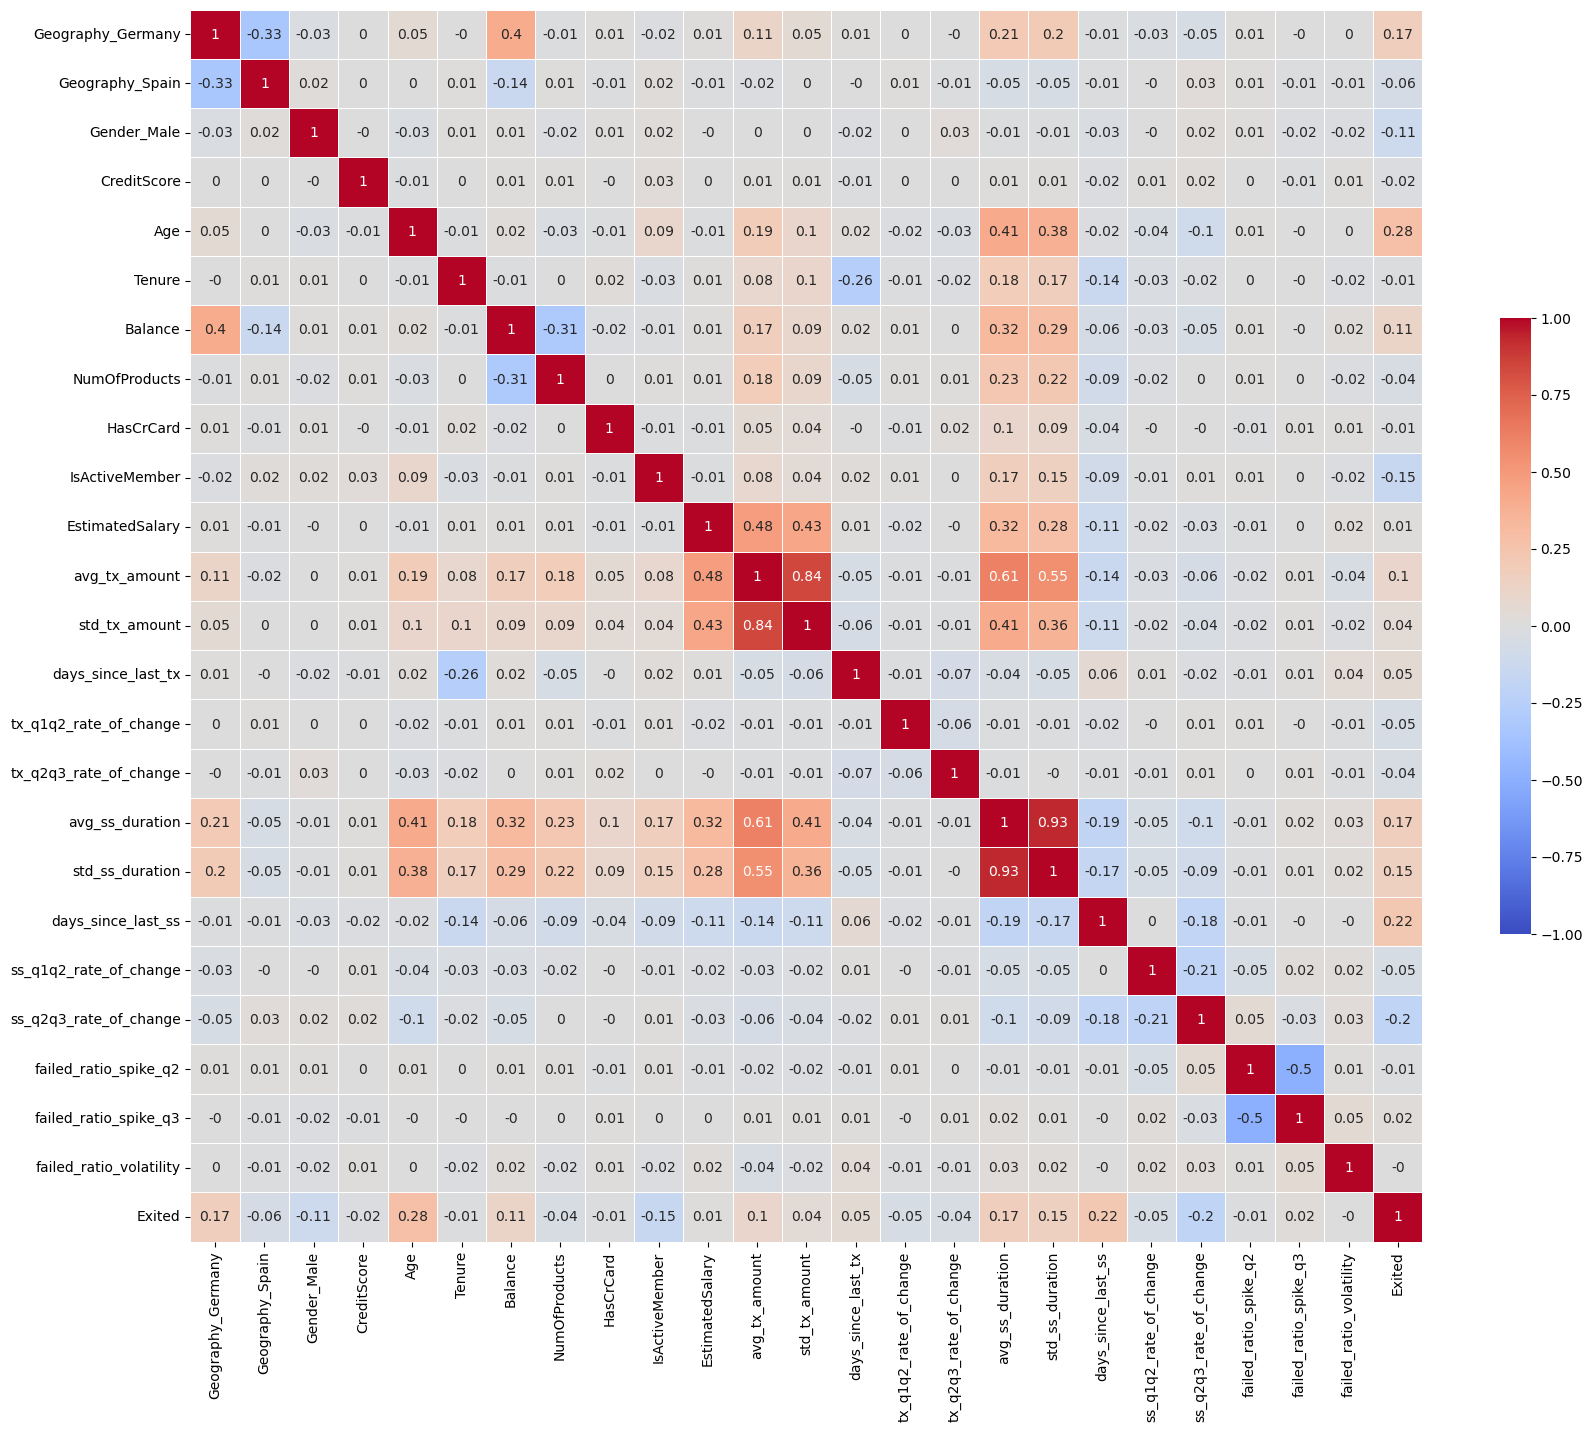

In [32]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

In [33]:
cols = corr.loc['Exited'].abs()[corr.loc['Exited'].abs() >= 0.04].index
corr_selected = corr[cols].loc[cols]

In [34]:
corr_selected

,Geography_Germany,Geography_Spain,Gender_Male,Age,Balance,IsActiveMember,avg_tx_amount,std_tx_amount,days_since_last_tx,tx_q1q2_rate_of_change,tx_q2q3_rate_of_change,avg_ss_duration,std_ss_duration,days_since_last_ss,ss_q1q2_rate_of_change,ss_q2q3_rate_of_change,Exited
Geography_Germany,1.000000,-0.330721,-0.028136,0.045715,0.402514,-0.022131,0.114397,0.054070,0.006129,0.003041,-0.001999,0.205582,0.197240,-0.007697,-0.026073,-0.047905,0.172920
Geography_Spain,-0.330721,1.000000,0.016233,0.000262,-0.136107,0.018661,-0.018949,0.002479,-0.000074,0.009642,-0.013038,-0.054258,-0.050856,-0.010516,-0.000664,0.029510,-0.059454
Gender_Male,-0.028136,0.016233,1.000000,-0.026783,0.009461,0.019843,0.002978,0.000716,-0.023942,0.004319,0.033507,-0.007150,-0.007032,-0.025424,-0.004501,0.020910,-0.106878
Age,0.045715,0.000262,-0.026783,1.000000,0.023071,0.089045,0.187908,0.100279,0.018593,-0.020794,-0.028796,0.413626,0.377822,-0.022019,-0.040585,-0.095554,0.282657
Balance,0.402514,-0.136107,0.009461,0.023071,1.000000,-0.013101,0.172854,0.091189,0.022820,0.014965,0.000389,0.319287,0.293704,-0.059399,-0.025513,-0.054756,0.112380
IsActiveMember,-0.022131,0.018661,0.019843,0.089045,-0.013101,1.000000,0.075618,0.035540,0.019486,0.009904,0.002239,0.173581,0.153348,-0.090761,-0.007635,0.011200,-0.154107
avg_tx_amount,0.114397,-0.018949,0.002978,0.187908,0.172854,0.075618,1.000000,0.836707,-0.050283,-0.010851,-0.013940,0.606334,0.547538,-0.139646,-0.032810,-0.058884,0.102442
std_tx_amount,0.054070,0.002479,0.000716,0.100279,0.091189,0.035540,0.836707,1.000000,-0.062783,-0.012658,-0.013869,0.405778,0.362778,-0.106577,-0.016520,-0.039192,0.042118
days_since_last_tx,0.006129,-0.000074,-0.023942,0.018593,0.022820,0.019486,-0.050283,-0.062783,1.000000,-0.013729,-0.070880,-0.044408,-0.046116,0.057745,0.006062,-0.019597,0.049588
tx_q1q2_rate_of_change,0.003041,0.009642,0.004319,-0.020794,0.014965,0.009904,-0.010851,-0.012658,-0.013729,1.000000,-0.064721,-0.013302,-0.013376,-0.015059,-0.003606,0.009668,-0.047778


In [35]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

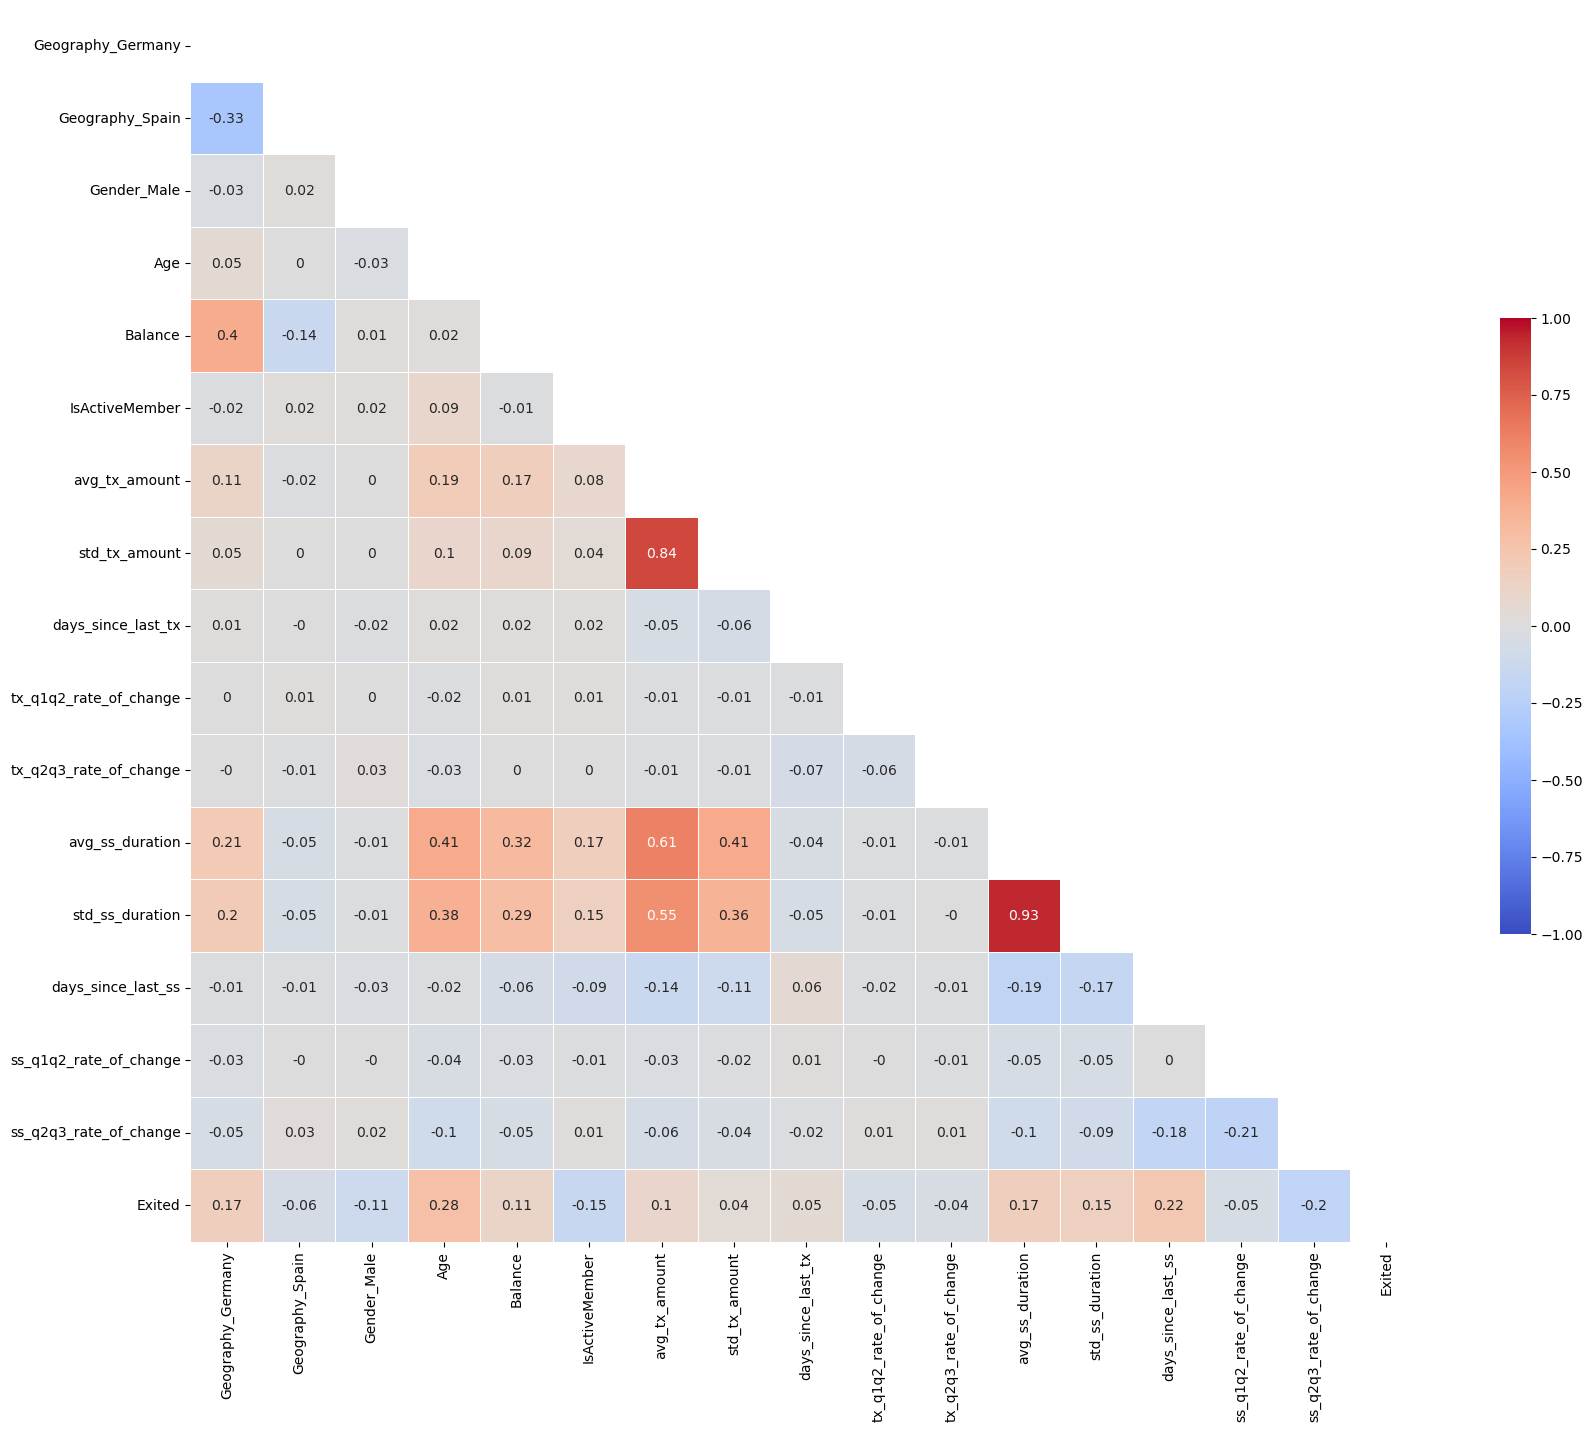

In [36]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='coolwarm')
fig.savefig(IMG_PATH / 'corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

In [37]:
corr_features = corr_selected.index.to_list()

## <font color='#c37171'>**Train Test Split**</font>

In [38]:
y = df_encoded['Exited']
X = df_encoded.drop('Exited', axis=1)

In [39]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
X_train.shape, X_test.shape

((7347, 24), (1837, 24))

## <font color='#c37171'>**Escalado Variables Numéricas**</font>

In [41]:
X.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [42]:
col_order = X.columns

In [43]:
numericas = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
             'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
             'days_since_last_tx', 'tx_q1q2_rate_of_change',
             'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
             'days_since_last_ss', 'ss_q1q2_rate_of_change',
             'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
             'failed_ratio_spike_q3', 'failed_ratio_volatility']

# 2. Separar las columnas numéricas y binarias/categóricas
X_train_num = X_train[numericas]
X_test_num = X_test[numericas]

X_train_binary = X_train.drop(numericas, axis=1)
X_test_binary = X_test.drop(numericas, axis=1)

# 3. Escalar solo las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# 4. Reconstruir los DataFrames escalados, PRESERVANDO EL ÍNDICE
X_train_cols = pd.DataFrame(X_train_scaled, columns=numericas, index=X_train_num.index)
X_test_cols = pd.DataFrame(X_test_scaled, columns=numericas, index=X_test_num.index)

# 5. Concatenar los DataFrames con los índices ahora alineados
X_train_final = pd.concat([X_train_cols, X_train_binary], axis=1)
X_test_final = pd.concat([X_test_cols, X_test_binary], axis=1)

# 6. Verificación de las formas correctas
print(X_train_final.shape, X_test_final.shape)

(7347, 24) (1837, 24)


In [44]:
X_train = X_train_final[col_order].copy()
X_test = X_test_final[col_order].copy()

## <font color='#c37171'>**Balance del dataset**</font>

In [45]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [46]:
"""
nearmiss = NearMiss(version=3)
X_train, y_train = nearmiss.fit_resample(X_train, y_train)
"""

'\nnearmiss = NearMiss(version=3)\nX_train, y_train = nearmiss.fit_resample(X_train, y_train)\n'

In [47]:
X_train.shape, y_train.shape

((11930, 24), (11930,))

In [48]:
y_train.sum()

5965

# <font color='#315aa0'>**Modeling**</font>

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## <font color='#c37171'>**Baseline Model - Decision Tree Classifier**</font>

In [50]:
X_train.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [51]:
best_models = []

In [52]:
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=42)
baseline_cross_val_results = cross_validate(baseline_model, X_train, y_train, cv=skf, scoring='recall')

In [53]:
cv_score_interval(results=baseline_cross_val_results, 
                  nombre='Baseline Model',
                  score='Recall')

Recall promedio de Baseline Model: 0.8756
Desviación estándar del Recall de Baseline Model: 0.009
El Recall de Baseline Model estará entre [0.8576,0.8936] con un 95% de confianza


In [54]:
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [55]:
baseline_train_results = metricas_evaluacion(baseline_model,
                                        X_train,
                                        y_train,
                                        nombre='Baseline Model')
baseline_train_results

{'Model': 'Baseline Model',
 'Accuracy': 0.9292,
 'Precision': 0.928,
 'Recall': 0.9306,
 'F1-score': 0.9293,
 'AUC': 0.9797,
 'Umbral': 0.5}

In [56]:
baseline_results = metricas_evaluacion(baseline_model,
                                        X_test,
                                        y_test,
                                        nombre='Baseline Model')

In [57]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.8138,
 'Precision': 0.5036,
 'Recall': 0.6145,
 'F1-score': 0.5535,
 'AUC': 0.7849,
 'Umbral': 0.5}

In [58]:
baseline_pred = baseline_model.predict(X_test)

In [59]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1492
           1       0.50      0.61      0.55       345

    accuracy                           0.81      1837
   macro avg       0.70      0.74      0.72      1837
weighted avg       0.83      0.81      0.82      1837



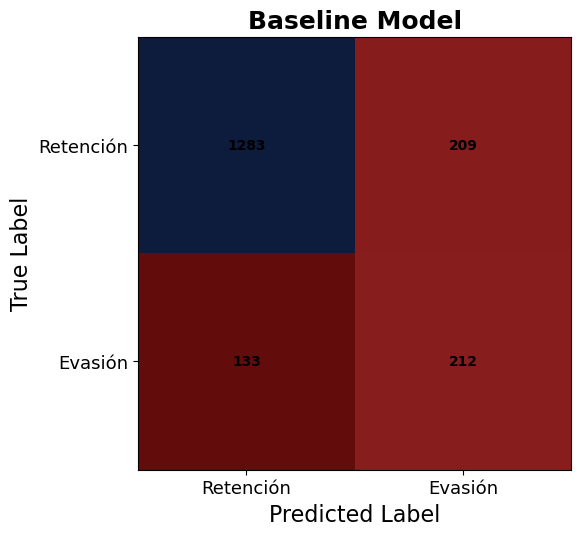

In [60]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

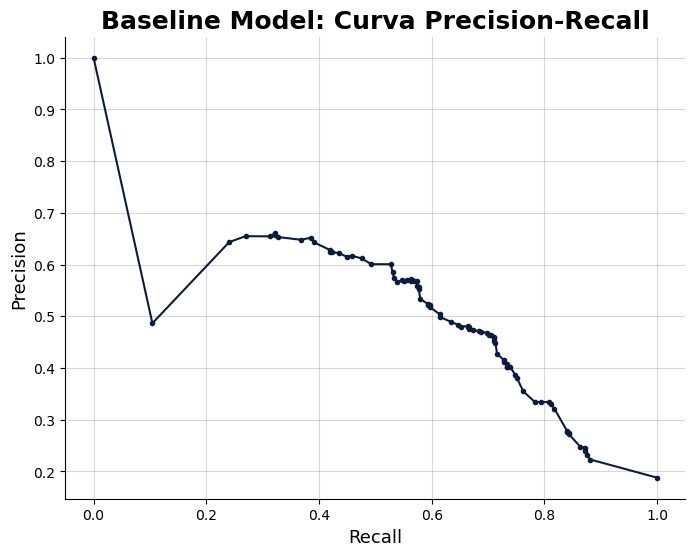

In [61]:
plot_precision_recall_curve(modelo=baseline_model,
                            x=X_test,
                            y=y_test,
                            nombre='Baseline Model')

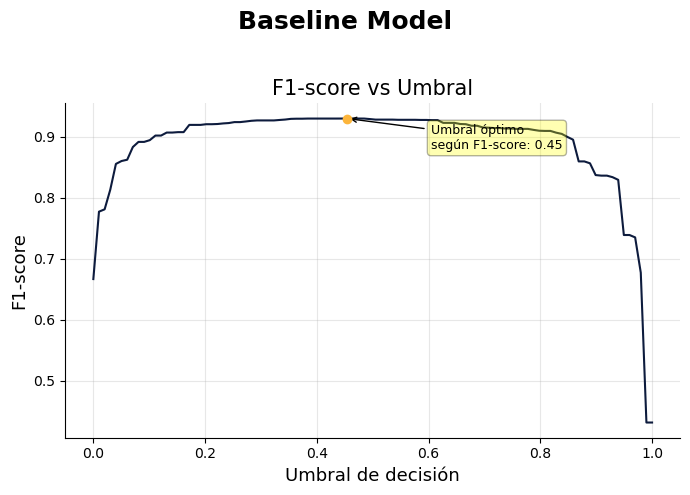

In [62]:
umbral_baseline, plot_umbral_baseline = plot_umbrales(modelo=baseline_model,
                                                      score='F1-score',
                                                      x=X_train,
                                                      y=y_train,
                                                      caja_x=0.15,
                                                      caja_y=0.05,
                                                      nombre='Baseline Model')

In [63]:
baseline_results_umbral = metricas_evaluacion(modelo=baseline_model,
                                              x_test=X_test,
                                              y_test=y_test,
                                              nombre='Baseline Model',
                                              umbral=umbral_baseline)
baseline_results_umbral

{'Model': 'Baseline Model',
 'Accuracy': 0.8019,
 'Precision': 0.4797,
 'Recall': 0.6522,
 'F1-score': 0.5528,
 'AUC': 0.7849,
 'Umbral': 0.4545454545454546}

In [64]:
baseline_importances = baseline_model.feature_importances_

In [65]:
df_baseline_importances = pd.DataFrame({'Feature': X_train.columns, 'Importancia': baseline_importances})
df_baseline_importances = df_baseline_importances.sort_values(by='Importancia', ascending=False)

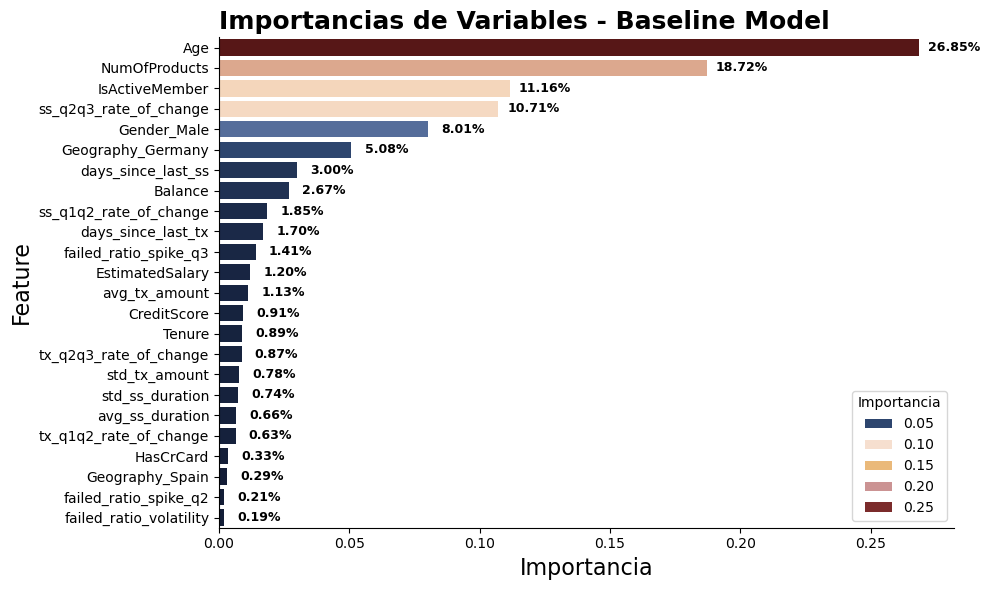

In [66]:
plot_analisis_variables(df=df_baseline_importances,
                        analisis='Importancia',
                        nombre_modelo='Baseline Model',
                        save='baseline_importances',
                        space=0.05,
                        cmap=reverse_custom_cmap)

### <font color='FCB53B'>**Importancias Baseline Model**</font>

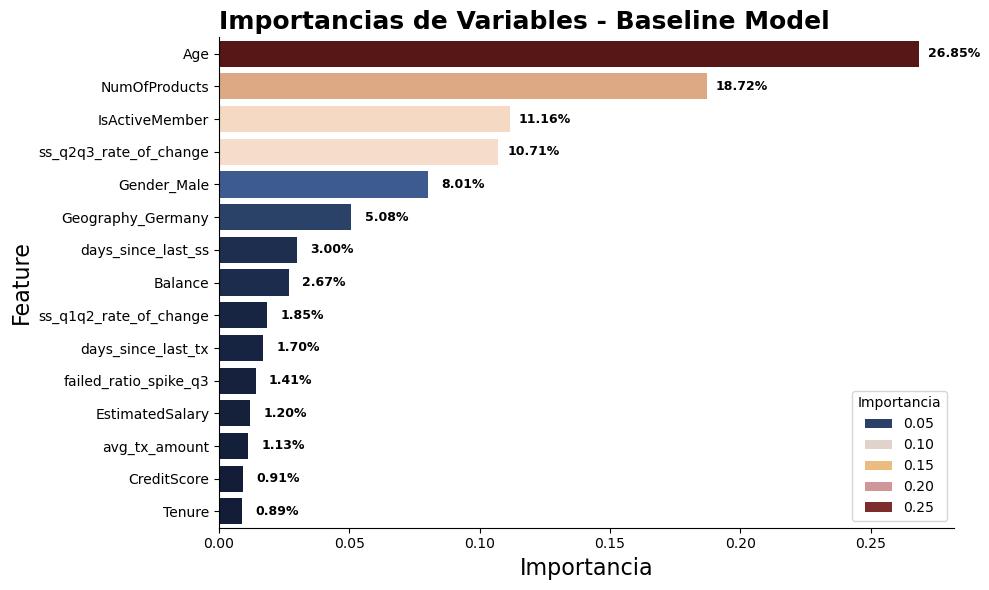

In [67]:
plot_analisis_variables(df=df_baseline_importances,
                        analisis='Importancia',
                        nombre_modelo='Baseline Model',
                        save='baseline_importances',
                        n_vars=15,
                        space=0.05,
                        cmap=reverse_custom_cmap)

In [68]:
df_baseline_importances.head(15)['Importancia'].sum()

0.9530472232817789

In [69]:
df_baseline_importances.head(15)

,Feature,Importancia
4,Age,0.268454
7,NumOfProducts,0.187214
9,IsActiveMember,0.111644
20,ss_q2q3_rate_of_change,0.107110
2,Gender_Male,0.080086
0,Geography_Germany,0.050782
18,days_since_last_ss,0.030002
6,Balance,0.026701
19,ss_q1q2_rate_of_change,0.018539
13,days_since_last_tx,0.017049


In [70]:
best_models.append(baseline_results_umbral)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.8019,0.4797,0.6522,0.5528,0.7849,0.454545


In [71]:
pd.DataFrame([baseline_train_results])

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Baseline Model,0.9292,0.928,0.9306,0.9293,0.9797,0.5


## <font color='#8b1f1f'>**Observaciones: Baseline Model - Decision Tree Classifier**</font>

| Model	          | Conjunto   | Accuracy   | Precision	| Recall	| F1-score	| AUC	  | Umbral   |
|-----------------|------------|------------|-----------|-----------|-----------|---------|----------|
| Baseline Model  | Train      | 0.9292	    | 0.928	    | 0.9306	| 0.9293	| 0.9797  | 0.5      |
| Baseline Model  | Test       | 0.8019	    | 0.4797	| 0.6522	| 0.5528	| 0.7849  | 0.454545 |

El modelo tomado como base (`Decision Tree Classifier`) muestra un elevado sobreajuste a los datos de entrenamiento. Esto era esperable ya que no se realizó ningún ajuste de hiperparámetros.

Sin embargo, como modelo base la capacidad de separar las clases es bastante buena, con un **score AUC = 0.7849** en los datos de prueba. Esto indica que existe poder predictivo en el presente dataset. Por lo que se realizarán diversos experimentos con el objetivo de encontrar el modelo que mejor comprenda el patrón presente en los datos.

## <font color='#c37171'>**Logistic Regression**</font>

In [72]:
lr_results_tracking = []

### <font color='#FCB53B'>**Logistic Regression 1  - max_iter=100**</font>

In [73]:
lr_1 = LogisticRegression(max_iter=100, random_state=42)

In [74]:
lr_1.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [75]:
lr_1_train = metricas_evaluacion(lr_1,
                                X_train,
                                y_train,
                                nombre='Train LogisticRegression 1')

lr_1_train

{'Model': 'Train LogisticRegression 1',
 'Accuracy': 0.7907,
 'Precision': 0.7866,
 'Recall': 0.7978,
 'F1-score': 0.7922,
 'AUC': 0.8685,
 'Umbral': 0.5}

In [76]:
lr_results_tracking.append(lr_1_train)

In [77]:
lr_1_results = metricas_evaluacion(lr_1,
                                    X_test,
                                    y_test,
                                    nombre='LogisticRegression 1')

In [78]:
lr_1_results

{'Model': 'LogisticRegression 1',
 'Accuracy': 0.7714,
 'Precision': 0.4334,
 'Recall': 0.7072,
 'F1-score': 0.5374,
 'AUC': 0.8277,
 'Umbral': 0.5}

In [79]:
lr_results_tracking.append(lr_1_results)

In [80]:
lr_1_coef = lr_1.coef_

In [81]:
df_lr_1_coef = pd.DataFrame({'Feature': X_train.columns, 'Coeficiente': lr_1_coef[0]})
df_lr_1_coef = df_lr_1_coef.sort_values(by='Coeficiente', ascending=False)
df_lr_1_coef

,Feature,Coeficiente
0,Geography_Germany,0.931135
4,Age,0.824143
18,days_since_last_ss,0.410966
11,avg_tx_amount,0.404902
16,avg_ss_duration,0.229064
22,failed_ratio_spike_q3,0.089944
6,Balance,0.054227
13,days_since_last_tx,0.021677
1,Geography_Spain,0.000357
5,Tenure,-0.009119


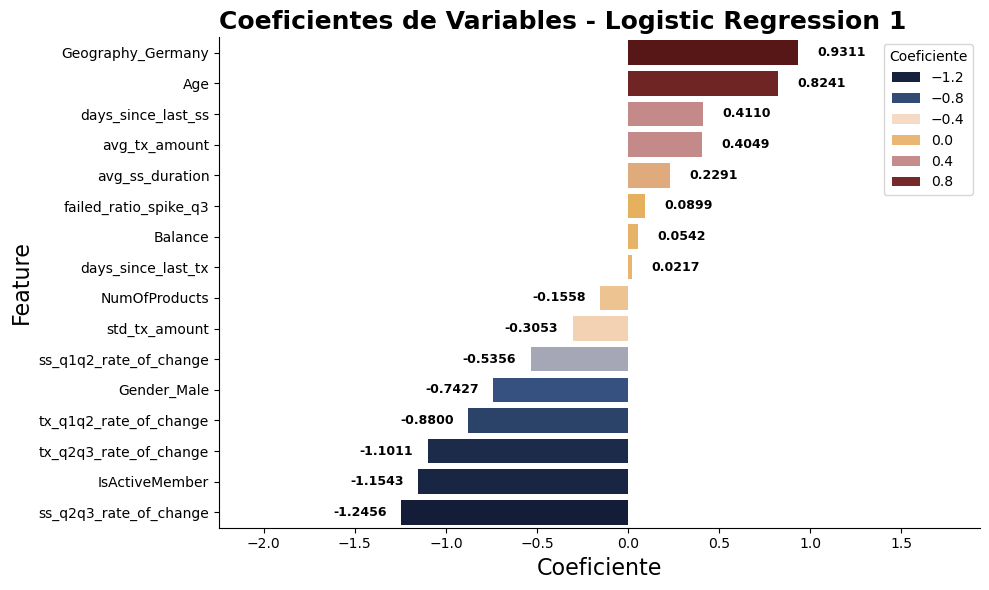

In [82]:
plot_analisis_variables(df=df_lr_1_coef,
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression 1',
                        save='lr_1',
                        n_vars=16,
                        space=0.4,
                        cmap=reverse_custom_cmap)

In [83]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7907,0.7866,0.7978,0.7922,0.8685,0.5
1,LogisticRegression 1,0.7714,0.4334,0.7072,0.5374,0.8277,0.5


### <font color='#FDD2A9'>**Observaciones Logistic Regression 1**</font>

In [84]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7907,0.7866,0.7978,0.7922,0.8685,0.5
1,LogisticRegression 1,0.7714,0.4334,0.7072,0.5374,0.8277,0.5


### <font color='#FCB53B'>**Logistic Regression 2 - Regularización C=0.1**</font>

In [85]:
lr_2 = LogisticRegression(max_iter=100, C=0.1, random_state=42)

In [86]:
lr_2.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

In [87]:
lr_2_train = metricas_evaluacion(lr_2,
                                X_train,
                                y_train,
                                nombre='Train LogisticRegression 2')
lr_2_train

{'Model': 'Train LogisticRegression 2',
 'Accuracy': 0.7904,
 'Precision': 0.7856,
 'Recall': 0.799,
 'F1-score': 0.7922,
 'AUC': 0.8684,
 'Umbral': 0.5}

In [88]:
lr_results_tracking.append(lr_2_train)

In [89]:
lr_2_results = metricas_evaluacion(lr_2,
                                    X_test,
                                    y_test,
                                    nombre='LogisticRegression 2')
lr_2_results

{'Model': 'LogisticRegression 2',
 'Accuracy': 0.7692,
 'Precision': 0.4303,
 'Recall': 0.7072,
 'F1-score': 0.5351,
 'AUC': 0.8285,
 'Umbral': 0.5}

In [90]:
lr_results_tracking.append(lr_2_results)

In [91]:
lr_2_coef = lr_2.coef_
df_lr_2_coef = pd.DataFrame({'Feature': X_train.columns, 'Coeficiente': lr_2_coef[0]})
df_lr_2_coef = df_lr_2_coef.sort_values(by='Coeficiente', ascending=False)
df_lr_2_coef

,Feature,Coeficiente
0,Geography_Germany,0.896718
4,Age,0.816104
18,days_since_last_ss,0.410726
11,avg_tx_amount,0.390269
16,avg_ss_duration,0.217666
22,failed_ratio_spike_q3,0.086368
6,Balance,0.060985
13,days_since_last_tx,0.027812
5,Tenure,-0.004285
1,Geography_Spain,-0.009310


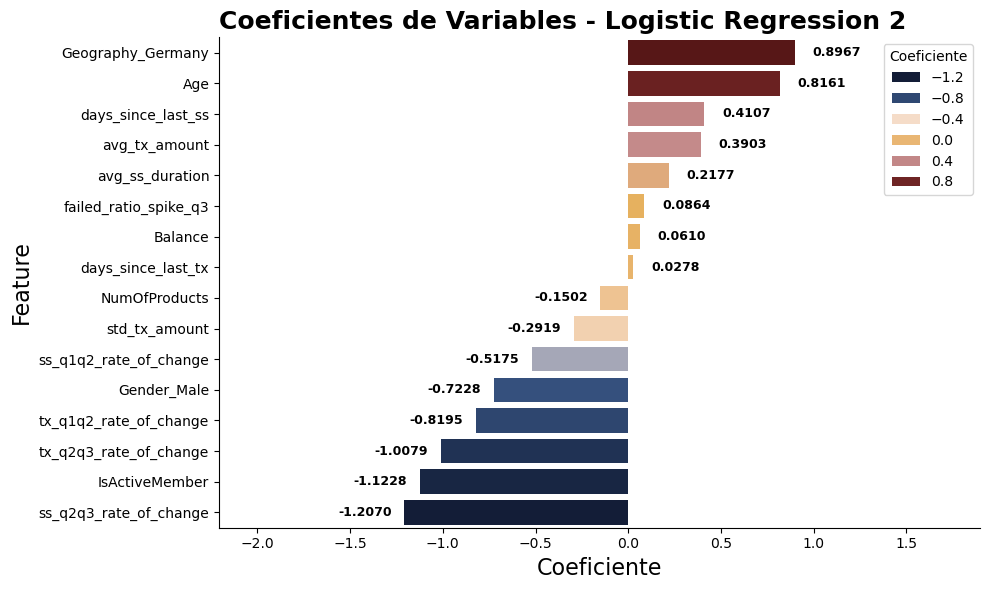

In [92]:
plot_analisis_variables(df=df_lr_2_coef,
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression 2',
                        save='lr_2',
                        n_vars=16,
                        space=0.4,
                        cmap=reverse_custom_cmap)

In [93]:
pd.DataFrame(lr_results_tracking)

,Model,Accuracy,Precision,Recall,F1-score,AUC,Umbral
0,Train LogisticRegression 1,0.7907,0.7866,0.7978,0.7922,0.8685,0.5
1,LogisticRegression 1,0.7714,0.4334,0.7072,0.5374,0.8277,0.5
2,Train LogisticRegression 2,0.7904,0.7856,0.7990,0.7922,0.8684,0.5
3,LogisticRegression 2,0.7692,0.4303,0.7072,0.5351,0.8285,0.5


## <font color='#c37171'>**Random Forest**</font>

### <font color='#FCB53B'>**Random Forest 1  - max_depth=10**</font>

In [94]:
rf_results_tracking = []

In [95]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42)

rf_1_cv_results = cross_validate(rf_1, X_train, y_train, cv=skf, scoring='recall')

In [96]:
cv_score_interval(results=rf_1_cv_results, 
                  nombre='RandomForest 1',
                  score='Recall')

Recall promedio de RandomForest 1: 0.9168
Desviación estándar del Recall de RandomForest 1: 0.0044
El Recall de RandomForest 1 estará entre [0.9080,0.9256] con un 95% de confianza


In [97]:
rf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [98]:
rf_1_pred = rf_1.predict(X_test)

In [99]:
print(classification_report(y_test, rf_1_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1492
           1       0.66      0.59      0.63       345

    accuracy                           0.87      1837
   macro avg       0.79      0.76      0.77      1837
weighted avg       0.86      0.87      0.86      1837



In [100]:
X_train.columns

Index(['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'avg_tx_amount', 'std_tx_amount',
       'days_since_last_tx', 'tx_q1q2_rate_of_change',
       'tx_q2q3_rate_of_change', 'avg_ss_duration', 'std_ss_duration',
       'days_since_last_ss', 'ss_q1q2_rate_of_change',
       'ss_q2q3_rate_of_change', 'failed_ratio_spike_q2',
       'failed_ratio_spike_q3', 'failed_ratio_volatility'],
      dtype='object')

In [101]:
metricas_evaluacion(rf_1,
                    X_train,
                    y_train,
                    nombre='RandomForest 1')

{'Model': 'RandomForest 1',
 'Accuracy': 0.9619,
 'Precision': 0.9654,
 'Recall': 0.9581,
 'F1-score': 0.9617,
 'AUC': 0.9939,
 'Umbral': 0.5}

In [102]:
metricas_evaluacion(rf_1,
                    X_test,
                    y_test,
                    nombre='RandomForest 1')

{'Model': 'RandomForest 1',
 'Accuracy': 0.8672,
 'Precision': 0.6634,
 'Recall': 0.5942,
 'F1-score': 0.6269,
 'AUC': 0.8789,
 'Umbral': 0.5}

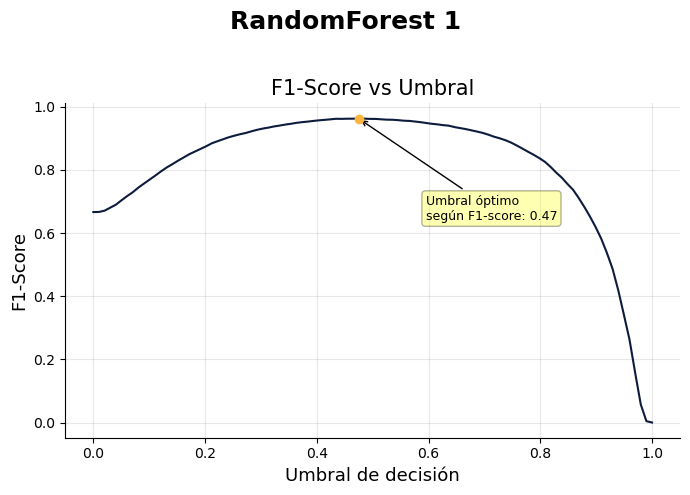

In [103]:
umbral_rf_1, plot_umbral_rf1 = plot_umbrales(modelo=rf_1, 
                                score='F1-Score',
                                x=X_train,
                                y=y_train,
                                caja_x=0.12, 
                                caja_y=0.32, 
                                nombre='RandomForest 1')

In [104]:
rf_1_results_umbral = metricas_evaluacion(rf_1,
                                          X_test,
                                          y_test,
                                          nombre='RandomForest 1',
                                          umbral=umbral_rf_1)
rf_1_results_umbral

{'Model': 'RandomForest 1',
 'Accuracy': 0.8677,
 'Precision': 0.65,
 'Recall': 0.6406,
 'F1-score': 0.6453,
 'AUC': 0.8789,
 'Umbral': 0.4747474747474748}

In [105]:
rf_1_importances = rf_1.feature_importances_
df_rf_1_importances = pd.DataFrame({'Feature': X_train.columns, 'Importancia': rf_1_importances})
df_rf_1_importances = df_rf_1_importances.sort_values(by='Importancia', ascending=False)
df_rf_1_importances

,Feature,Importancia
4,Age,0.174133
20,ss_q2q3_rate_of_change,0.115487
9,IsActiveMember,0.114940
7,NumOfProducts,0.103453
0,Geography_Germany,0.071577
2,Gender_Male,0.063956
18,days_since_last_ss,0.050215
13,days_since_last_tx,0.045928
6,Balance,0.030311
16,avg_ss_duration,0.025875


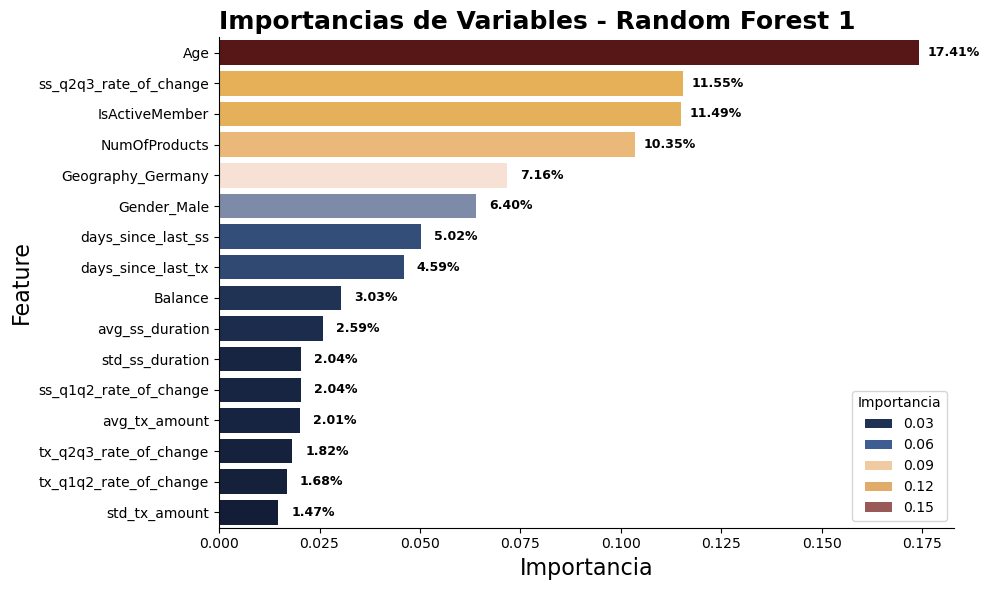

In [106]:
plot_analisis_variables(df=df_rf_1_importances,
                        analisis='Importancia',
                        nombre_modelo='Random Forest 1',
                        save='rf_1',
                        n_vars=16,
                        space=0.05,
                        cmap=reverse_custom_cmap)